In [242]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

In [243]:
num_features = 3
num_frames = 3
input_size = num_features * num_frames
output_size = num_features

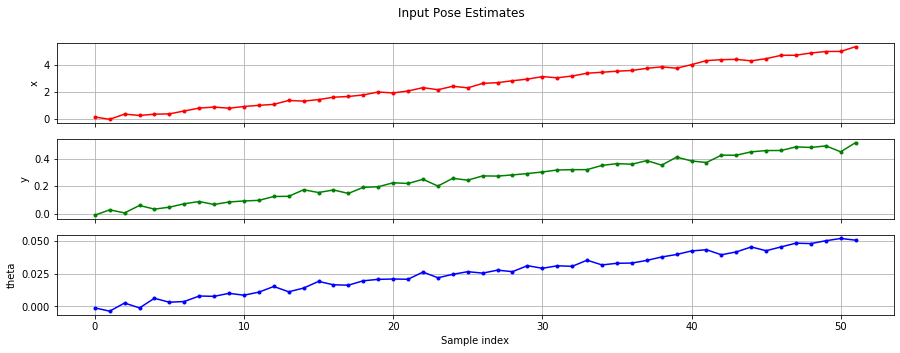

In [244]:
# Creating the artificial dataset
dim1_data = np.arange(0,5.2,0.1)
dim2_data = np.arange(0,0.52,0.01)
dim3_data = np.arange(0,0.052,0.001)

for i in range(len(dim1_data)):
    dim1_data[i] += np.random.randn()*0.1
    dim2_data[i] += np.random.randn()*0.02
    dim3_data[i] += np.random.randn()*0.002

dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()
dim2_data_scaled = (dim2_data - dim2_data.mean())/dim2_data.std()
dim3_data_scaled = (dim3_data - dim3_data.mean())/dim3_data.std()

# Plot subfigures
fig,axs = plt.subplots(3,figsize=(15,5))
fig.suptitle('Input Pose Estimates')
axs[0].plot(dim1_data,'r.-')
axs[0].set(ylabel = 'x')
axs[1].plot(dim2_data,'g.-')
axs[1].set(ylabel = 'y')
axs[2].plot(dim3_data,'b.-')
axs[2].set(ylabel = 'theta')
for ax in axs.flat:
    ax.set(xlabel='Sample index')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [245]:
dim1_data

array([ 0.16243454, -0.00729686,  0.37448118,  0.27506296,  0.36775828,
        0.39001087,  0.60422137,  0.81447237,  0.89008559,  0.80642306,
        0.93083392,  1.01547944,  1.08826897,  1.37420442,  1.32528417,
        1.43630044,  1.6120159 ,  1.66477502,  1.77911058,  1.99311021,
        1.92456021,  2.07019072,  2.31316294,  2.16035037,  2.41600371,
        2.29777988,  2.62300947,  2.67992419,  2.81982997,  2.93775638,
        3.11989179,  3.03612696,  3.16561463,  3.3698032 ,  3.44034916,
        3.51693824,  3.57337815,  3.73151594,  3.8350546 ,  3.73842276,
        3.9975383 ,  4.29671017,  4.36276508,  4.38633453,  4.27699419,
        4.43764693,  4.6801861 ,  4.68982541,  4.85294653,  4.96183803,
        4.96898832,  5.31869796])

In [246]:
# For the two frame case, input tensor holds x, y, and theta data in frame 1, frame 2
# [x1,y1,th1,x2,y2,th2]
# These are offset, so that x1 goes up until the second last frame
# (current frame is treated as future prediction)

# output tensor holds single frame, for x, y, and theta values
# This is cropped to exclude the first n frames (n=2 here) and run up until the end
# So a synthesised 'future' value to aim for

t_x = torch.tensor(dim1_data_scaled)
t_y = torch.tensor(dim2_data_scaled)
t_theta = torch.tensor(dim3_data_scaled)

x_data = torch.zeros(len(dim1_data)-num_frames,input_size)
start_idx = 0
end_idx = len(x_data)
frame_idx = num_frames - 1

for i in range(num_frames):
    x_data[:,frame_idx*num_features+2] = t_theta[start_idx:end_idx]
    x_data[:,frame_idx*num_features+1] = t_y[start_idx:end_idx]
    x_data[:,frame_idx*num_features] = t_x[start_idx:end_idx]
    start_idx+=1
    end_idx+=1
    frame_idx-=1 # older frames are assigned to later columns
    
y_data = torch.zeros(len(dim1_data)-num_frames,output_size)
y_data[:,0] = t_x[num_frames:]
y_data[:,1] = t_y[num_frames:]
y_data[:,2] = t_theta[num_frames:]

In [247]:
x_rows = x_data.size()[0]
train_validate_ratio = 0.9
training_idx_limit = int(train_validate_ratio * x_rows)

x_train = x_data[:training_idx_limit,:]
x_valid = x_data[training_idx_limit:,:]

y_train = y_data[:training_idx_limit,:]
y_valid = y_data[training_idx_limit:,:]

print('x_data dimensions:',x_data.size())
print('x_train dimensions:',x_train.size())
print('x_valid dimensions:',x_valid.size())
print('y_data dimensions:',y_data.size())
print('y_train dimensions:',y_train.size())
print('y_valid dimensions:',y_valid.size())

x_data dimensions: torch.Size([49, 9])
x_train dimensions: torch.Size([44, 9])
x_valid dimensions: torch.Size([5, 9])
y_data dimensions: torch.Size([49, 3])
y_train dimensions: torch.Size([44, 3])
y_valid dimensions: torch.Size([5, 3])


In [248]:
class Pose_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,output_size)

    def forward(self, xb):
        return self.lin(xb)
    
epochs = 10
lr = 0.2
batch_size = 10

model = Pose_Logistic()
criterion = nn.MSELoss()
Loss = []  # variable for storing losses after each epoch

train_ds = TensorDataset(x_train,y_train)
valid_ds = TensorDataset(x_valid,y_valid)

def loss_batch(model,loss_func,xb,yb,opt=None):
    loss=loss_func(model(xb),yb)
    
    if opt is not None:
        Loss.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(),len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def get_model():
    model = Pose_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [249]:
loss_func = criterion

train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.17027324438095093
1 0.04368601366877556
2 0.02719457633793354
3 0.036246828734874725
4 0.017750559374690056
5 0.029581831768155098
6 0.020457325503230095
7 0.022551823407411575
8 0.015185083262622356
9 0.017786778509616852


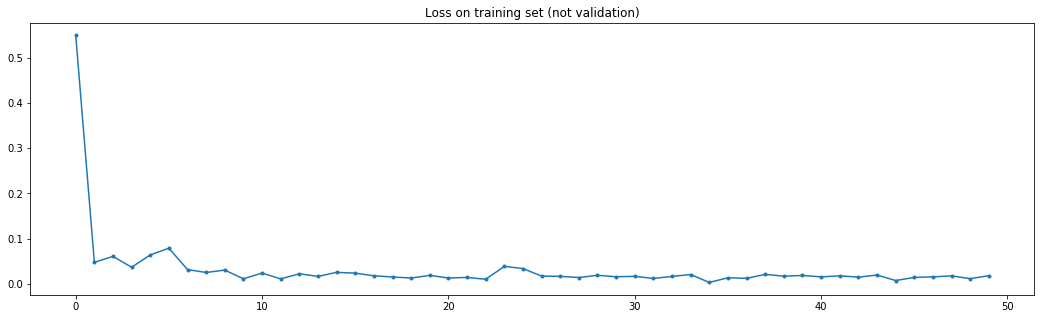

In [250]:
plt.figure(figsize=(18,5))
plt.title("Loss on training set (not validation)")
plt.plot(Loss,'.-')